# House Prices - Advanced Regression Techniques

## 引入相关的库与读取原始数据

In [1]:
import pandas as pd
import numpy as np
import torch
import My_utils
from torch import nn
from matplotlib import pyplot as plt

train_data=pd.read_csv('train.csv')
test_data=pd.read_csv('test.csv')
print(train_data.shape)
print(test_data.shape)
all_features=pd.concat((train_data.iloc[:,1:-1],test_data.iloc[:,1:]))
print(all_features.shape)

(1460, 81)
(1459, 80)
(2919, 79)


## 数据预处理

In [2]:
all_features=pd.get_dummies(all_features,dummy_na=True)
all_features.shape

(2919, 330)

In [3]:
numeric_feature=all_features.dtypes[all_features.dtypes!='object'].index
all_features[numeric_feature]=all_features[numeric_feature].apply(lambda x:(x-x.mean())/(x.std()))
all_features[numeric_feature]=all_features[numeric_feature].fillna(0)#缺失的填上0

## 生成训练集和测试集

In [4]:
num_train=train_data.shape[0]
train_features=torch.tensor(all_features[:num_train].values,dtype=torch.float32)
test_features=torch.tensor(all_features[num_train:].values,dtype=torch.float32)
train_labels=torch.tensor(train_data.SalePrice.values.reshape((-1,1)),dtype=torch.float32)

## 训练与验证模型的可行性

### 定义网络、损失函数、迭代器以及超参数

In [5]:
in_features=train_features.shape[1]
dropout=0.5
net=nn.Sequential(nn.Linear(in_features,1024),
                  nn.ReLU(),
                  nn.Dropout(dropout),
                  nn.Linear(1024,512),
                  nn.ReLU(),
                  nn.Dropout(dropout),
                  nn.Linear(512,1))
loss=nn.MSELoss()

### 误差衡量标准
本题关心的是相对误差而不是绝对误差

In [6]:
def log_rmse(net,features,labels):
    clipped_preds=torch.clamp(net(features),1,float('inf'))
    rmse=torch.sqrt(loss(torch.log(clipped_preds),torch.log(labels)))
    return rmse.item()

### 定义训练函数

In [7]:
def train(train_features,train_labels,test_features,test_labels,net,num_epochs,loss,learning_rate,weight_decay,batch_size):
    train_loss,test_loss=[],[]
    train_iter=My_utils.load_array((train_features,train_labels),batch_size)
    updater=torch.optim.Adam(net.parameters(),
                             lr=learning_rate,
                             weight_decay=weight_decay)
    for epoch in range(num_epochs):
        for X,y in train_iter:
            updater.zero_grad()
            l=loss(net(X),y)
            l.backward()
            updater.step()
        train_loss.append(log_rmse(net,train_features,train_labels))
        if test_labels is not None:
            test_loss.append(log_rmse(net,test_features,test_labels))
    return train_loss,test_loss

### 进行k折交叉验证，验证模型的可行性

In [8]:
def get_K_fold_data(k,i,X,y):
    assert k>1
    fold_size=X.shape[0]//k
    X_train,y_train=None,None
    for j in range(k):
        idx=slice(j*fold_size,(j+1)*fold_size)
        X_part,y_part=X[idx,:],y[idx,:]
        if j==i:#选取作为验证集
            X_valid,y_valid=X_part,y_part
        elif X_train is None:#训练集的初始化
            X_train,y_train=X_part,y_part
        else:#训练集的添加
            X_train=torch.cat((X_train,X_part),0)
            y_train=torch.cat((y_train,y_part),0)
    return X_train,y_train,X_valid,y_valid#返回训练集和验证集

def K_fold_verify(net,k,X,y,num_epochs,loss,learning_rate,weight_decay,batch_size):
    train_loss_sum,valid_loss_sum=0,0
    for i in range(k):
        X_train,y_train,X_valid,y_valid=get_K_fold_data(k,i,X,y)
        train_loss,valid_loss=train(X_train,y_train,X_valid,y_valid,net,num_epochs,loss,learning_rate,weight_decay,batch_size)
        train_loss_sum+=train_loss[-1]
        valid_loss_sum+=valid_loss[-1]
        if i==0:
            My_utils.plot(list(range(1,num_epochs+1)),[train_loss,valid_loss],xlabel='epoch',ylabel='rmse',yscale='log',xlim=[1,num_epochs],legend=['train_loss','valid_loss'])
        print(f'第{i+1}折训练误差：{float(train_loss[-1])}， ' f'第{i+1}折验证误差：{float(valid_loss[-1])}')
    return train_loss_sum/k,valid_loss_sum/k

### 进行验证

第1折训练误差：12.028136253356934， 第1折验证误差：12.040851593017578
第2折训练误差：1.6297907829284668， 第2折验证误差：1.6416466236114502
第3折训练误差：0.9745497703552246， 第3折验证误差：0.9950248599052429
第4折训练误差：0.6458155512809753， 第4折验证误差：0.5967794060707092
第5折训练误差：0.4573136568069458， 第5折验证误差：0.4537608325481415
平均训练误差：3.1471212029457094，平均验证误差：3.1456126630306245


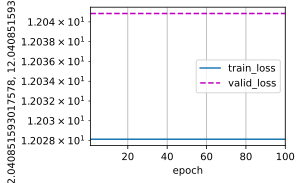

In [9]:
k=5
num_epochs=100
lr=30
weight_decay=0
batch_size=100
train_loss_mean,valid_loss_mean=K_fold_verify(net,k,train_features,train_labels,num_epochs,loss,lr,weight_decay,batch_size)
print(f'平均训练误差：{train_loss_mean}，' f'平均验证误差：{valid_loss_mean}')

## 预测

训练误差：0.39933478832244873


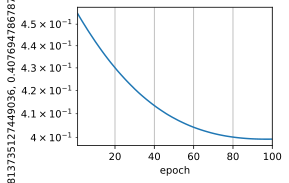

In [10]:
def train_pred(net,train_features,test_features,train_labels,test_data,num_epochs,loss,learning_rate,weight_decay,batch_size):
    train_loss,_=train(train_features,train_labels,None,None,net,num_epochs,loss,learning_rate,weight_decay,batch_size)
    My_utils.plot(list(range(1,num_epochs+1)),train_loss,xlabel='epoch',ylabel='rmse',xlim=[1,num_epochs],yscale='log')
    print(f'训练误差：{float(train_loss[-1])}')
    pred=net(test_features).detach().numpy()
    test_data['SalePrice']=pd.Series(pred.reshape(1,-1)[0])
    submission=pd.concat((test_data['Id'],test_data['SalePrice']),axis=1)
    submission.to_csv('submission.csv',index=False)
train_pred(net,train_features,test_features,train_labels,test_data,num_epochs,loss,lr,weight_decay,batch_size)